# Stock Price Trend Classification with Random Forest

## Overview 
Many individuals aim to invest their money in stocks and take advantage of the seemingly quick, but also risky way of making money. The movement of stock prices are impacted by so many factors such as crowd sentiment, world news, macroeconomic movement, and the intrinsic value of a company’s assets. Stock analysis is divided into two main categories: fundamental and technical analysis. Fundamental analysis focuses on the broader picture; it places an emphasis on a company’s financial records and market capitalization, while technical analysis focuses on creating an almost scientific method of stock prediction that’s based on patterns, trends, and momentum of a stock’s price. Keeping track of all the indicators and signals dictated in the technical analysis of a stock can be complex and time-consuming to do by hand, which is why machine learning techniques can be used to aid this process. Techniques such as Random Forest can essentially capture all these indicators and signals as features and classify the stock price as going up or down. This kind of classification offers investors a buy or sell signal from the technical perspective of stock prediction, which they can verify with real-world sentiments to help make decisions about their investments. 

In [2]:
#Set Up of features dataframe & feature engineering

import pandas as pd
import numpy as np
import modules.features as ft
from stock_indicators import indicators, Quote
from stock_indicators import CandlePart
from datetime import datetime
import yfinance as yf


In [3]:
sp500 = yf.Ticker("^GSPC")
hist = sp500.history(period = "max")
hist = hist.reset_index().dropna()

In [4]:
hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [5]:
hist.shape

(24426, 8)

In [7]:
quotes_list = [
    Quote(d, o, h, l, c, v)
    for d, o, h, l, c, v
    in zip(hist['Date'], hist['Open'], hist['High'], 
            hist['Low'], hist['Close'], hist['Volume'])
]
features_df = pd.merge(ft.bollinger_bands(quotes_list), ft.calc_macd_signal(
    quotes_list)).merge(ft.calc_RSI(quotes_list)).merge(
        ft.calc_trend_strength(quotes_list))
features_df["Close Trend"] = ft.calc_lagged_close(hist, 5)
features_df["Close"] = hist["Close"]
features_df = features_df.dropna()

In [8]:
features_df.columns

Index(['Date', 'SMA', 'LB', 'UP', 'Z_Score', 'Macd Values', 'Signal Values',
       'Macd Area Sum', 'Macd Area Change', 'Macd Difference', 'RSI',
       'RSI MEAN', 'RSI STD', 'RSI Z-Score', 'ADX', 'PDI', 'MDI',
       'Close Trend', 'Close'],
      dtype='object')

In [11]:
features_df.head()

,Date,SMA,LB,UP,Z_Score,Macd Values,Signal Values,Macd Area Sum,Macd Area Change,Macd Difference,RSI,RSI MEAN,RSI STD,RSI Z-Score,ADX,PDI,MDI,Close Trend,Close
47,1928-03-09,17.3605,16.869278,17.851722,2.318710,0.066352,-0.012187,0.362377,0.024065,1,67.219551,46.723998,9.769606,2.097889,15.423715,67.219551,32.780449,1.0,17.93
48,1928-03-12,17.3830,16.822747,17.943253,2.202575,0.100851,0.010421,0.417244,0.091398,1,68.796738,47.713877,10.944576,1.926330,17.007270,68.796738,31.203262,1.0,18.00
49,1928-03-13,17.4020,16.797696,18.006304,1.714368,0.120349,0.032406,0.478409,0.161869,1,64.950559,48.530489,11.604988,1.414915,17.928259,64.950559,35.049441,1.0,17.92
50,1928-03-14,17.4265,16.779777,18.073223,1.557081,0.135051,0.052935,0.547776,0.232797,1,65.212372,49.547970,12.145969,1.289679,18.820865,65.212372,34.787628,1.0,17.93
51,1928-03-15,17.4600,16.755415,18.164585,1.731515,0.156199,0.073588,0.630356,0.306082,1,68.733564,50.813750,12.776279,1.402585,20.152741,68.733564,31.266436,1.0,18.07


In [9]:
#Class Balance
print(((features_df[features_df["Close Trend"] == 1].shape)[0]/features_df.shape[0]) * 100)
print(((features_df[features_df["Close Trend"] == 0].shape)[0]/features_df.shape[0]) * 100)

56.20821198572542
43.79178801427458


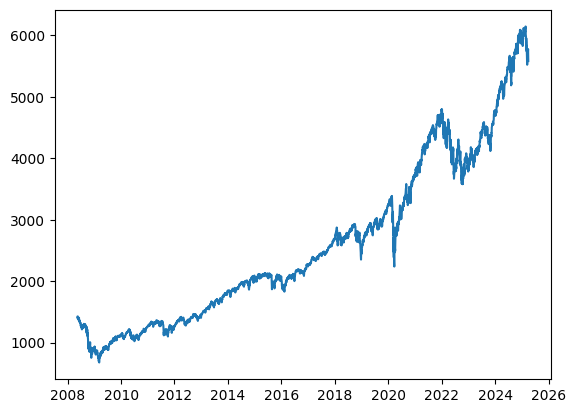

In [10]:
import matplotlib.pyplot as plt 
plot_data = features_df
x1 = plot_data.loc["2018-01-01":]
plt.plot(x1["Date"], x1["Close"])

In [12]:
xTrain, yTrain, xTest, yTest = ft.test_train(features_df, 0.8)

In [13]:
xTrain = xTrain.drop(["Date", "Close"], axis=1)
xTest = xTest.drop(["Date", "Close"], axis=1)

In [14]:
xTrain.head()

,SMA,LB,UP,Z_Score,Macd Values,Signal Values,Macd Area Sum,Macd Area Change,Macd Difference,RSI,RSI MEAN,RSI STD,RSI Z-Score,ADX,PDI,MDI
47,17.3605,16.869278,17.851722,2.318710,0.066352,-0.012187,0.362377,0.024065,1,67.219551,46.723998,9.769606,2.097889,15.423715,67.219551,32.780449
48,17.3830,16.822747,17.943253,2.202575,0.100851,0.010421,0.417244,0.091398,1,68.796738,47.713877,10.944576,1.926330,17.007270,68.796738,31.203262
49,17.4020,16.797696,18.006304,1.714368,0.120349,0.032406,0.478409,0.161869,1,64.950559,48.530489,11.604988,1.414915,17.928259,64.950559,35.049441
50,17.4265,16.779777,18.073223,1.557081,0.135051,0.052935,0.547776,0.232797,1,65.212372,49.547970,12.145969,1.289679,18.820865,65.212372,34.787628
51,17.4600,16.755415,18.164585,1.731515,0.156199,0.073588,0.630356,0.306082,1,68.733564,50.813750,12.776279,1.402585,20.152741,68.733564,31.266436


In [15]:
#Class Balances
print(len(np.where(yTrain == 1)[0])/len(yTrain), len(np.where(yTrain == 0)[0])/len(yTrain))
print(len(np.where(yTest == 1)[0])/len(yTest), len(np.where(yTest == 0)[0])/len(yTest))

0.5551453622519612 0.44485463774803874
0.5898277276456112 0.41017227235438886


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

In [17]:
RF_model = RandomForestClassifier(n_estimators=200, random_state=42)

In [18]:
yfit = RF_model.fit(xTrain, yTrain)

In [19]:
y_train_pred = RF_model.predict(xTrain)
y_test_pred = RF_model.predict(xTest)

In [20]:
metric_vals = [accuracy_score(yTrain, y_train_pred), f1_score(yTrain, y_train_pred), precision_score(yTrain, y_train_pred), recall_score(yTrain, y_train_pred)]
metric_names = ["accuracy", "f1-score", "precision", "recall"]
pd.DataFrame({"metric": metric_names, "score": metric_vals})

,metric,score
0,accuracy,1.0
1,f1-score,1.0
2,precision,1.0
3,recall,1.0


In [21]:
metric_vals = [accuracy_score(yTest, y_test_pred), f1_score(yTest, y_test_pred), precision_score(yTest, y_test_pred), recall_score(yTest, y_test_pred)]
metric_names = ["accuracy", "f1-score", "precision", "recall"]
pd.DataFrame({"metric": metric_names, "score": metric_vals})

,metric,score
0,accuracy,0.857670
1,f1-score,0.880221
2,precision,0.873886
3,recall,0.886648


In [22]:
from sklearn.metrics import roc_auc_score
roc_score_train = roc_auc_score(yTrain, RF_model.predict_proba(xTrain)[:, 1])
roc_score_test = roc_auc_score(yTest, RF_model.predict_proba(xTest)[:, 1])

roc_score_train, roc_score_test #this is great

(np.float64(1.0), np.float64(0.9380567628650903))

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yTest, y_test_pred)
print(cm)

[[1632  368]
 [ 326 2550]]


In [47]:
importances = RF_model.feature_importances_
columns = xTrain.columns
importance_df = pd.DataFrame({"Feature":columns, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending = False)
importance_df

,Feature,Importance
12,RSI Z-Score,0.238524
3,Z_Score,0.199128
9,RSI,0.120776
13,ADX,0.061705
8,Macd Difference,0.049986
4,Macd Values,0.040576
10,RSI MEAN,0.036433
7,Macd Area Change,0.036091
15,MDI,0.034550
5,Signal Values,0.034455


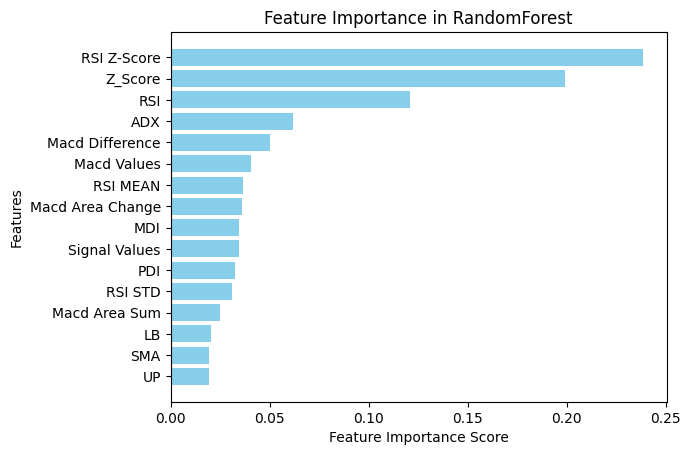

In [25]:
plt.barh(importance_df['Feature'], importance_df['Importance'], color = 'skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in RandomForest")
plt.gca().invert_yaxis()  # Flip y-axis for better readability
plt.show()

In [26]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(RF_model, xTrain, yTrain, cv = 10)

In [27]:
np.mean(cv_scores)

np.float64(0.8639187793242125)

In [28]:
from sklearn.model_selection import GridSearchCV
RF_model.get_params()
#Important Parameters: Max Features, Number of Estimators

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Tuning Hyperparameters
## Number of Estimators

In [29]:
random_grid = {'n_estimators': np.linspace(400, 1000, 6, dtype=int)}
grid_search_estim = GridSearchCV(estimator=RF_model, param_grid=random_grid, cv=10, verbose=2, n_jobs=-1)
grid_search_estim.fit(xTrain, yTrain)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 400,  520,  640,  760,  880, 1000])},
             verbose=2)

In [30]:
cv_results_e = grid_search_estim.cv_results_
cv_score_means_e = np.ones(6)
for i in range(0, 6):
    cv_score = 0
    for j in range(0, 10):  
        cv_score += cv_results_e[f"split{j}_test_score"][i]
    cv_score_means_e[i] = cv_score/10

In [31]:
best_n_estim = grid_search_estim.best_estimator_.n_estimators

In [32]:
np.mean(cv_score_means_e)

np.float64(0.8648417467264213)

Text(0.5, 1.0, 'CV Score Against Number of Estimators')

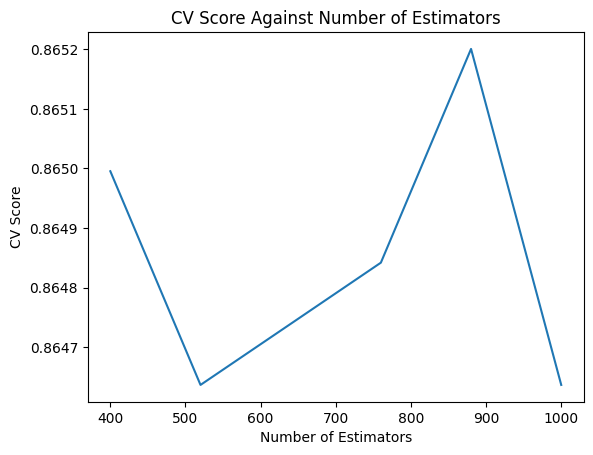

In [33]:
cv_scores_df_e = pd.DataFrame({"scores": cv_score_means_e}, index=random_grid["n_estimators"])
plt.plot(cv_scores_df_e)
plt.ylabel("CV Score")
plt.xlabel("Number of Estimators")
plt.title("CV Score Against Number of Estimators")

## Maximum Features

In [34]:
random_grid_f = {'max_features': np.linspace(8, 50, 11, dtype=int)}
grid_search_f = GridSearchCV(estimator=RF_model, param_grid=random_grid_f, cv=10, verbose=2, n_jobs=-1)
grid_search_f.fit(xTrain, yTrain)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': array([ 8, 12, 16, 20, 24, 29, 33, 37, 41, 45, 50])},
             verbose=2)

In [35]:
cv_results_f = grid_search_f.cv_results_
cv_score_means_f = np.ones(len(random_grid_f['max_features']))
for i in range(0, len(random_grid_f['max_features'])):
    cv_score = 0
    for j in range(0, 10):  
        cv_score += cv_results_f[f"split{j}_test_score"][i]
    cv_score_means_f[i] = cv_score/10
print(cv_score_means_f)

[0.86679029 0.86597038 0.86361153 0.86361153 0.86361153 0.86361153
 0.86361153 0.86361153 0.86361153 0.86361153 0.86361153]


In [36]:
np.mean(cv_score_means_f)

np.float64(0.8641149515101333)

In [37]:
np.linspace(8, 50, 11, dtype=int)

array([ 8, 12, 16, 20, 24, 29, 33, 37, 41, 45, 50])

In [38]:
best_max_f = grid_search_f.best_estimator_.max_features

Text(0.5, 1.0, 'CV Score Against Number of Max Features')

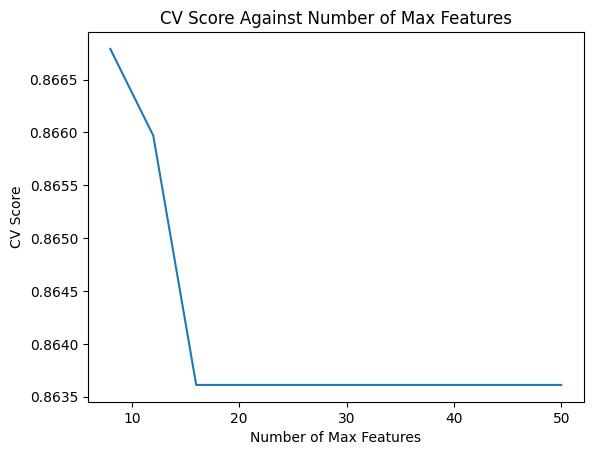

In [39]:
cv_scores_df_f = pd.DataFrame({"scores": cv_score_means_f}, index=random_grid_f["max_features"])
plt.plot(cv_scores_df_f)
plt.ylabel("CV Score")
plt.xlabel("Number of Max Features")
plt.title("CV Score Against Number of Max Features")


In [40]:
cv_scores_df_f["scores"]

8     0.866790
12    0.865970
16    0.863612
20    0.863612
24    0.863612
29    0.863612
33    0.863612
37    0.863612
41    0.863612
45    0.863612
50    0.863612
Name: scores, dtype: float64

In [41]:
rf_tuned = RandomForestClassifier(n_estimators=best_n_estim, max_features=best_max_f, random_state=42)
yfit = rf_tuned.fit(xTrain, yTrain)

In [42]:
result = rf_tuned.predict(xTest)

In [43]:
metric_vals = [accuracy_score(yTest, y_test_pred), f1_score(yTest, y_test_pred), precision_score(yTest, y_test_pred), recall_score(yTest, y_test_pred)]
metric_names = ["accuracy", "f1-score", "precision", "recall"]
pd.DataFrame({"metric": metric_names, "score": metric_vals})

,metric,score
0,accuracy,0.857670
1,f1-score,0.880221
2,precision,0.873886
3,recall,0.886648


In [44]:
roc_score_train = roc_auc_score(yTrain, rf_tuned.predict_proba(xTrain)[:, 1])
roc_score_test = roc_auc_score(yTest, rf_tuned.predict_proba(xTest)[:, 1])

roc_score_train, roc_score_test #this is great

(np.float64(1.0), np.float64(0.9371793289290682))

In [45]:
cv_scores = cross_val_score(rf_tuned, xTrain, yTrain, cv = 10)

In [46]:
np.mean(cv_scores)

np.float64(0.8674058536713585)